# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [2]:
# Download the data
if not os.path.exists('./content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O ./content/aerialseq.npy
if not os.path.exists('./content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O ./content/antseq.npy

# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In [123]:
from scipy.interpolate import RectBivariateSpline

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    It_rbs = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    It1_rbs = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    x_grid, y_grid = np.meshgrid(np.arange(It.shape[1]), np.arange(It.shape[0]))
    old_coords = np.vstack([x_grid.flatten(), y_grid.flatten(), np.ones_like(x_grid.flatten())])
    # ===== your code here! =====
    for ii in range(num_iters):
        new_coords = M @ old_coords

        mask = ((new_coords[0,:] >= 0) & 
                (new_coords[0,:] < It.shape[1]) & 
                (new_coords[1,:] >= 0) & 
                (new_coords[1,:] < It.shape[0]))
        
        It1_warp = It1_rbs.ev(new_coords[1], new_coords[0]).reshape(It.shape)
        
        # dW/dp = [[x, y, 1, 0, 0, 0], [0, 0, 0, x, y, 1]]
        
        # grad_x = It1_rbs.ev(y_grid, x_grid, dy=1)
        # grad_y = It1_rbs.ev(y_grid, x_grid, dx=1)

        grad_x = np.gradient(It1_warp, axis=1).flatten()
        grad_y = np.gradient(It1_warp, axis=0).flatten()
        
        # dI/dx' = [dI/dx, dI/dy]
        # dI/dx' * dW/dp = [dI/dx * x, dI/dx * y, dI/dx, dI/dy * x, dI/dy * y, dI/dy]

        A = np.vstack([grad_x.flatten() * x_grid.flatten(), 
                       grad_x.flatten() * y_grid.flatten(), 
                       grad_x.flatten(), 
                       grad_y.flatten() * x_grid.flatten(), 
                       grad_y.flatten() * y_grid.flatten(), 
                       grad_y.flatten()]).T
        
        b = (It - It1_warp).flatten()
        dp = np.linalg.lstsq(A[mask], b[mask], rcond=None)[0]
        
        if np.linalg.norm(dp) < threshold:
            break
        M += np.reshape(dp, M.shape)
        
    # ===== End of code =====
    return M

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

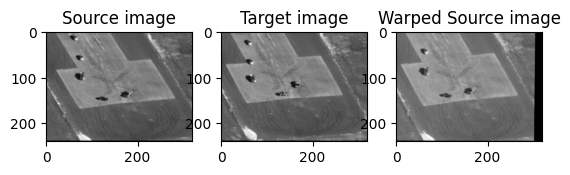

In [124]:
import cv2

num_iters = 200
threshold = 0.01
seq = np.load("./content/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# Q3.2: Moving Object Detection (10 points)

In [156]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    warped_It = cv2.warpAffine(It, -M, It.shape)
    # ===== End of code =====
    mask = np.abs(It1 - warped_It.T) > tolerance
    mask = binary_erosion(mask)
    mask = ~binary_dilation(mask)
    mask[-1,:] = ~mask[-1,:] 
    return mask


## Q3.3: Tracking with affine motion (10 points)

In [147]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    rects =[]
    It = seq[:,:,0]
    masks = []

    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        masks.append(SubtractDominantMotion(seq[:,:,i-1], seq[:,:,i], num_iters, threshold, tolerance))

    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [148]:
seq = np.load("./content/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [00:16<00:00,  7.38it/s]



Ant Sequence takes 16.857641 seconds


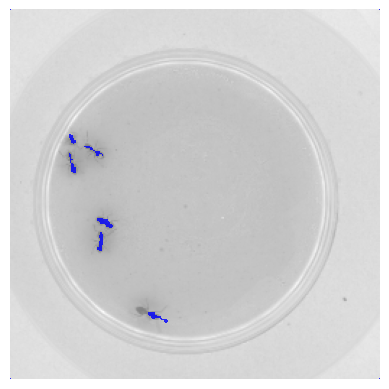

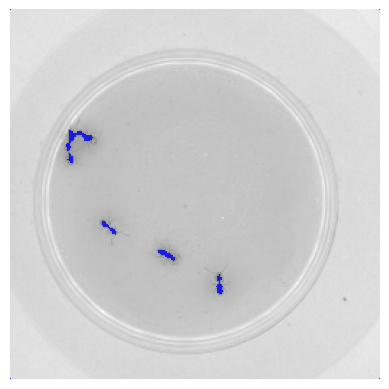

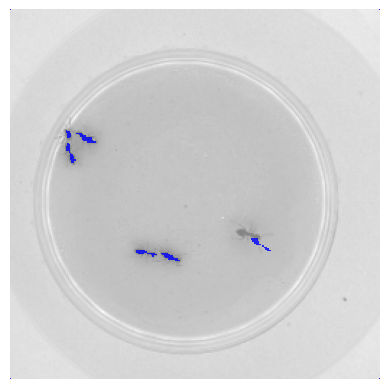

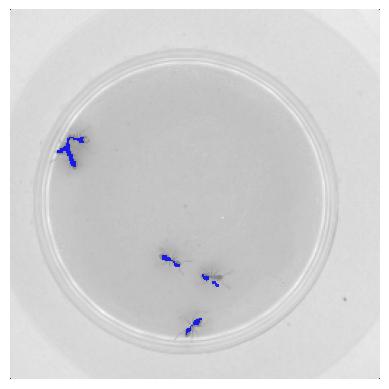

In [149]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [157]:
seq = np.load("./content/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.3

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [00:42<00:00,  3.53it/s]


Ant Sequence takes 42.298250 seconds


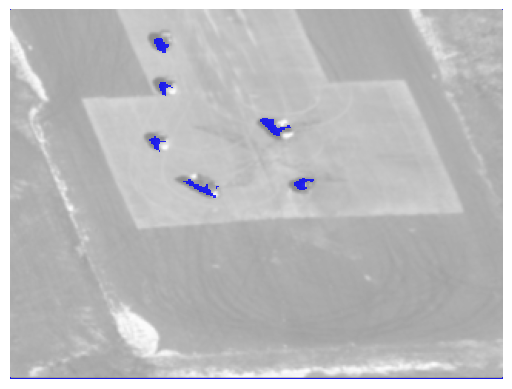

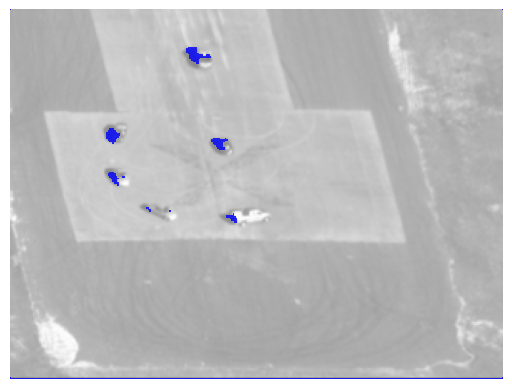

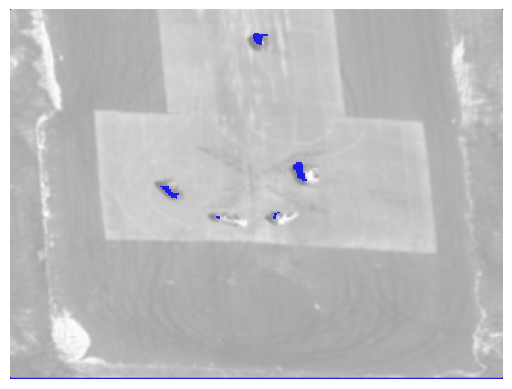

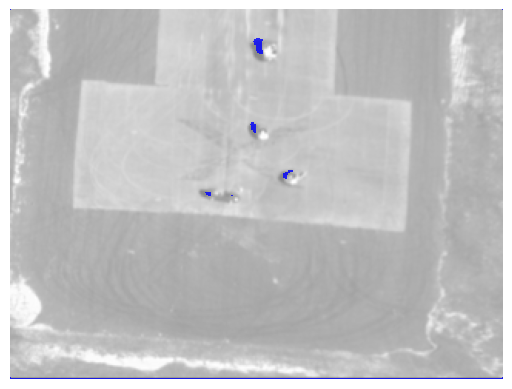

In [153]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')